### Preprocessing

In [32]:
# Libraries
# ============================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [33]:
# Data
# ============================================
sales = pd.read_csv('../data/sales_transactions.csv').drop_duplicates()
exhibitions = pd.read_csv('../data/store_exhibitions.csv').drop_duplicates()
stores = pd.read_csv('../data/store_metadata.csv').drop_duplicates()

In [34]:
# Cleaning
# ============================================
# Transform datetime columns
sales['Date'] = pd.to_datetime(sales['Date'])
sales['Year'] = sales['Date'].dt.isocalendar().year
sales['Week'] = sales['Date'].dt.isocalendar().week

# I create revenue column
sales['Revenue'] = sales['Price'] * sales['Units_Sold']

# as Exhibition is in week I transform Sales ina week df too
weekly_agg = sales.groupby(['Year', 'Week', 'Store_Id', 'Sku_Id']).agg({
    'Revenue': 'sum',
    'Units_Sold': 'sum'
}).reset_index()

# The price is a Weighted Price, to give importance the units sold
weekly_agg['Price'] = weekly_agg['Revenue'] / weekly_agg['Units_Sold']

# Delete Revenue, I don't need it
weekly_agg.drop(columns=['Revenue'], inplace=True)

In [35]:
# Preprocessing
# ============================================

# I merge weekly sales with exhibitions and stores
df = pd.merge(weekly_agg, exhibitions, on=['Year', 'Week', 'Store_Id', 'Sku_Id'], how='left')
df[['Method_1', 'Method_2', 'Method_3']] = df[['Method_1', 'Method_2', 'Method_3']].fillna(0)

# Clean atipics
# ============================================
# In this case I note that exist Year-Week-Storage-Sku that has more than one method. 

duplicated_rows = df[df.duplicated(subset=['Year', 'Week', 'Store_Id', 'Sku_Id'], keep=False)]
# Ver algunos ejemplos de duplicados
print(f"{'='*17} Duplicated records {'='*17}")
print(duplicated_rows.sort_values(['Year', 'Week', 'Store_Id', 'Sku_Id'])[['Year', 'Week', 'Store_Id', 'Sku_Id', 'Method_1', 'Method_2', 'Method_3']])
# I dropped it, because it is not common, 
# But, it can be an analysis by itself creating a "Combo" method.
size_df = len(df)
print(f"\nTotal Records without drop duplicates: {size_df}")

df = df.drop(index=duplicated_rows.index)
size_df_clean = len(df)

print(f"Total Records drop duplicates: {len(df)}")
print(f"Records deleted: {size_df - size_df_clean}")


================= Duplicated records =================
        Year  Week  Store_Id  Sku_Id  Method_1  Method_2  Method_3
10182   2023    14      3061     182       0.0       1.0       0.0
10183   2023    14      3061     182       0.0       0.0       1.0
70056   2023    25       111     728       0.0       1.0       0.0
70057   2023    25       111     728       0.0       0.0       1.0
76584   2023    26      1169     182       0.0       0.0       1.0
76585   2023    26      1169     182       0.0       1.0       0.0
427519  2024    34       113     727       0.0       1.0       1.0
427520  2024    34       113     727       0.0       0.0       1.0
457706  2024    39      1438     182       0.0       1.0       1.0
457707  2024    39      1438     182       0.0       0.0       1.0
559673  2025     4      2922     182       0.0       1.0       0.0
559674  2025     4      2922     182       0.0       0.0       1.0

Total Records without drop duplicates: 619706
Total Records drop duplicat

### Statistical incidence


In [36]:
# Basic analysis about the exhibition methods
print("=== DISTRIBUTION OF EXHIBITION METHODS ===")
for method in ['Method_1', 'Method_2', 'Method_3']:
    coverage = df[method].mean() * 100
    print(f"{method}: {coverage:.2f}% of coverage")

# Relation method vs sales
print("\n=== AVERAGE SALES WITH/WITHOUT METHODS ===")
for method in ['Method_1', 'Method_2', 'Method_3']:
    with_method = df[df[method] == 1]['Units_Sold'].mean()
    without_method = df[df[method] == 0]['Units_Sold'].mean()
    uplift = (with_method / without_method - 1) * 100
    print(f"{method}: {with_method:.2f} vs {without_method:.2f} → {uplift:+.2f}%")

=== DISTRIBUTION OF EXHIBITION METHODS ===
Method_1: 0.04% of coverage
Method_2: 2.14% of coverage
Method_3: 30.47% of coverage

=== AVERAGE SALES WITH/WITHOUT METHODS ===
Method_1: 152.49 vs 118.57 → +28.61%
Method_2: 152.53 vs 117.84 → +29.44%
Method_3: 163.35 vs 98.97 → +65.06%


In [37]:
# Features
features = ['Price', 'Method_1', 'Method_2', 'Method_3']
X = df[features]
X_ols = sm.add_constant(X)  # Intercept
y = df['Units_Sold']

# Ordinary least squares method
model = sm.OLS(y, X_ols).fit()
print(model.summary())


def sales_impact(model, scale):
    print("\n=== impact of exhibitions on sales ===")
    for method in ['Method_1', 'Method_2', 'Method_3']:
        if method in model.params:
            coef = model.params[method]
            pval = model.pvalues[method]

            if pval < 0.05:
                significance = "✓ SIGNIFICATIVO"
            else:
                significance = "✗ NO SIGNIFICATIVO"

            if scale == 'nominal':
                print(f"{method}: {coef:+.1f} (p-value: {pval:.4f}) {significance}")
            elif scale == 'log':
                effect_pct = (np.exp(coef) - 1) * 100
                print(f"{method}: {effect_pct:+.2f}% (p-value: {pval:.4f}) {significance}")

sales_impact(model,'nominal')
mse_ols = mean_squared_error(y,  model.predict(X_ols))


                            OLS Regression Results                            
Dep. Variable:             Units_Sold   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                 1.502e+04
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:34:03   Log-Likelihood:            -3.7151e+06
No. Observations:              619694   AIC:                         7.430e+06
Df Residuals:                  619689   BIC:                         7.430e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.4470      0.214    483.218      0.0

In [30]:
# log regression model
y_log = np.log(df['Units_Sold'] + 1)
model_log = sm.OLS(y_log, X_ols).fit()
print(model_log.summary())


sales_impact(model_log,'log')

mse_log = mean_squared_error(y,  model_log.predict(X_ols))

                            OLS Regression Results                            
Dep. Variable:             Units_Sold   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                 1.744e+04
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:26:19   Log-Likelihood:            -6.8256e+05
No. Observations:              619694   AIC:                         1.365e+06
Df Residuals:                  619689   BIC:                         1.365e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3700      0.002   2723.568      0.0

### Impact of exhibitions on sales

In [38]:
# Model: Decision Tree
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42, max_depth=4)
tree_model.fit(X, y)

# Error and predict
y_pred_tree = tree_model.predict(X)
mse_tree = mean_squared_error(y, y_pred_tree)
print(f'Decision Tree MSE: {mse_tree:.2f}')

# Feature importances
importances_rf = pd.Series(tree_model.feature_importances_, index=features)
print("\nRandom Forest Feature Importances:")

Decision Tree MSE: 8214.94

Random Forest Feature Importances:


In [39]:
# Model: Random Forest

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Error and predict
y_pred_rf = rf_model.predict(X)
mse_rf = mean_squared_error(y, y_pred_rf)
print(f'Random Forest MSE: {mse_rf:.2f}')

# Feature importances
importances_rf = pd.Series(rf_model.feature_importances_, index=features)
print("\nRandom Forest Feature Importances:")

Random Forest MSE: 2388.45

Random Forest Feature Importances:


In [40]:
# Model: XGBoost
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X, y)

# Error and predict
y_pred_xgb = xgb_model.predict(X)
mse_xgb = mean_squared_error(y, y_pred_xgb)
print(f'XGBoost MSE: {mse_xgb:.2f}')

# Feature importances
importances_xgb = pd.Series(xgb_model.feature_importances_, index=features)
print("\nXGBoost Feature Importances:")
print(importances_xgb.sort_values(ascending=False))


XGBoost MSE: 7791.41

XGBoost Feature Importances:
Method_3    0.767367
Price       0.214457
Method_2    0.016872
Method_1    0.001305
dtype: float32


In [41]:
# Model: lightgbm
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X, y)

# Error and predict
y_pred_lgb = lgb_model.predict(X)
mse_lgb = mean_squared_error(y, y_pred_lgb)
print(f'LightGBM MSE: {mse_lgb:.2f}')

# Feature importances
importances_lgb = pd.Series(lgb_model.feature_importances_, index=features)
print("\nLightGBM Feature Importances:")
print(importances_lgb.sort_values(ascending=False))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 619694, number of used features: 4
[LightGBM] [Info] Start training from score 118.584998


LightGBM MSE: 7771.86

LightGBM Feature Importances:
Price       2473
Method_3     283
Method_2     224
Method_1      20
dtype: int32


In [42]:
# Comparation between models
print(f"""
Comparación de MSE:
- Árbol de Decisión: {mse_tree:.2f}
- Random Forest: {mse_rf:.2f}
- XGBoost: {mse_xgb:.2f}
- LightGBM: {mse_lgb:.2f}
""")

mse_dict = {'DT':mse_tree,
'RF':mse_rf,
'XGB':mse_xgb,
'LGB':mse_lgb}

model_dict = {
    'DT': tree_model,
    'RF': rf_model,
    'XGB': xgb_model,
    'LGB': lgb_model
}

# Choose the best according MSE
best_model_name = min(mse_dict, key=mse_dict.get)
print(f"The best model is: {best_model_name} with MSE = {mse_dict[best_model_name]:.2f}")

best_model = model_dict[best_model_name]

# Features importances of the best model
importances = pd.Series(best_model.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

# Mostrar resultados
print("\nFeatures importances of the best model:")
print(importances)


Comparación de MSE:
- Árbol de Decisión: 8214.94
- Random Forest: 2388.45
- XGBoost: 7791.41
- LightGBM: 7771.86

The best model is: RF with MSE = 2388.45



Features importances of the best model:
Price       0.896049
Method_3    0.095462
Method_2    0.008283
Method_1    0.000207
dtype: float64


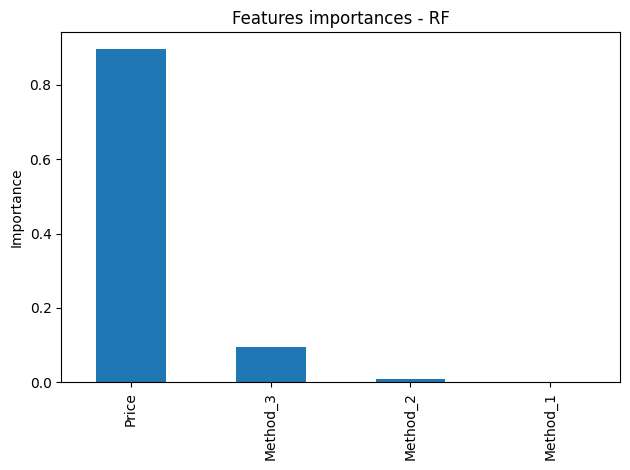

In [43]:
import matplotlib.pyplot as plt

importances.plot(kind='bar')
plt.title(f'Features importances - {best_model_name}')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
